In [1]:
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os
from functools import partial
from matplotlib import pyplot as plt
%pylab inline
import warnings
warnings.filterwarnings('ignore')
from keras.utils import np_utils

np.random.seed(42)

# stuff to make this work on GPUs
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
from emnist import extract_training_samples
from emnist import extract_test_samples
X_train, y_train = extract_training_samples('letters')
X_test, y_test = extract_test_samples('letters')
X_train = X_train/255.
X_test = X_test/255.
# jedes Pixel in allen Bildern einen Wert zwischen 0 und 1 hat
print(X_train.shape)
print(X_test.shape)
# 124800 Bilder fürs Trainieren
# 20800 Bilder fürs Testen

(124800, 28, 28)
(20800, 28, 28)


Text(0.5, 1.0, 'c')

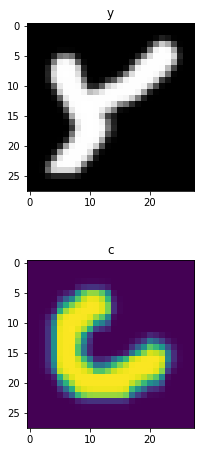

In [3]:
img_index_train = 8888 # das img_index. Image ausnehmen
img_train = X_train[img_index_train]
img_index_test = 1888
img_test = X_test[img_index_test]
plt.figure(figsize=(3,8))
plt.subplot(2, 1, 1)
plt.imshow(img_train.reshape((28,28)), cmap='gray')
plt.title(chr(y_train[img_index_train]+96))
plt.subplot(2, 1, 2)
plt.imshow(img_test.reshape((28,28)))
plt.title(chr(y_test[img_index_test]+96))

In [4]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
random.seed(4242)

print("Number of Training Images =", n_train)
print("Number of Test Images =    ", n_test)
print("Image Format =             ", image_shape)
print("Number of Classes =        ", n_classes)

Number of Training Images = 124800
Number of Test Images =     20800
Image Format =              (28, 28)
Number of Classes =         26


In [5]:
y_train_cat = np_utils.to_categorical(y_train-1, 26)
y_test_cat = np_utils.to_categorical(y_test-1, 26)

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print("Shape before = ", X_train.shape)
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 1)
print("Shape after  = ", X_train_reshaped.shape)

Shape before =  (124800, 28, 28)
Shape after  =  (124800, 28, 28, 1)


In [7]:
BATCH_SIZE = 100
EPOCHS     = 20

In [8]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [9]:
model = keras.models.Sequential()
# model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(DefaultConv2D(64, kernel_size=3, strides=1, input_shape=(28,28,1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=2, strides=2, padding="SAME"))
model.add(keras.layers.Dropout(0.4))
prev_filters = 64
#for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
for filters in [64] * 2 + [128] * 2 + [256] * 2:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(n_classes, activation="softmax"))

W0706 20:17:01.389120 4565716416 deprecation.py:506] From /Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        576       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 14, 14, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 14, 14, 64)        7

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
model.fit(X_train_reshaped, y_train_cat, 
          batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Epoch 1/20
124800/124800 [==============================] - 560s 4ms/sample - loss: 0.3818 - acc: 0.8786
Epoch 2/20
124800/124800 [==============================] - 560s 4ms/sample - loss: 0.1968 - acc: 0.9331
Epoch 3/20
124800/124800 [==============================] - 559s 4ms/sample - loss: 0.1709 - acc: 0.9412
Epoch 4/20
124800/124800 [==============================] - 560s 4ms/sample - loss: 0.1565 - acc: 0.9446
Epoch 5/20
124800/124800 [==============================] - 563s 5ms/sample - loss: 0.1433 - acc: 0.9490
Epoch 6/20
124800/124800 [==============================] - 565s 5ms/sample - loss: 0.1327 - acc: 0.9526
Epoch 7/20
124800/124800 [==============================] - 565s 5ms/sample - loss: 0.1255 - acc: 0.9542
Epoch 8/20
124800/124800 [==============================] - 564s 5ms/sample - loss: 0.1153 - acc: 0.9570
Epoch 9/20
124800/124800 [==============================] - 565s 5ms/sample - loss: 0.1074 - acc: 0.9594
Epoch 10/20
124800/124800 [============================

In [13]:
score = model.evaluate(X_test_reshaped, y_test_cat)

print('Result on Test Set')
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

20800/20800 [==============================] - 16s 792us/sample - loss: 0.2129 - acc: 0.9488
Result on Test Set
Test loss:     0.21286138405778957
Test accuracy: 0.94884616


In [14]:
resultingClasses = np.argmax(model.predict(X_test_reshaped), axis=1)
incorrects = np.nonzero(resultingClasses != y_test-1)
print("Total number of misclassifications: ", len(incorrects[0]))

Total number of misclassifications:  1064


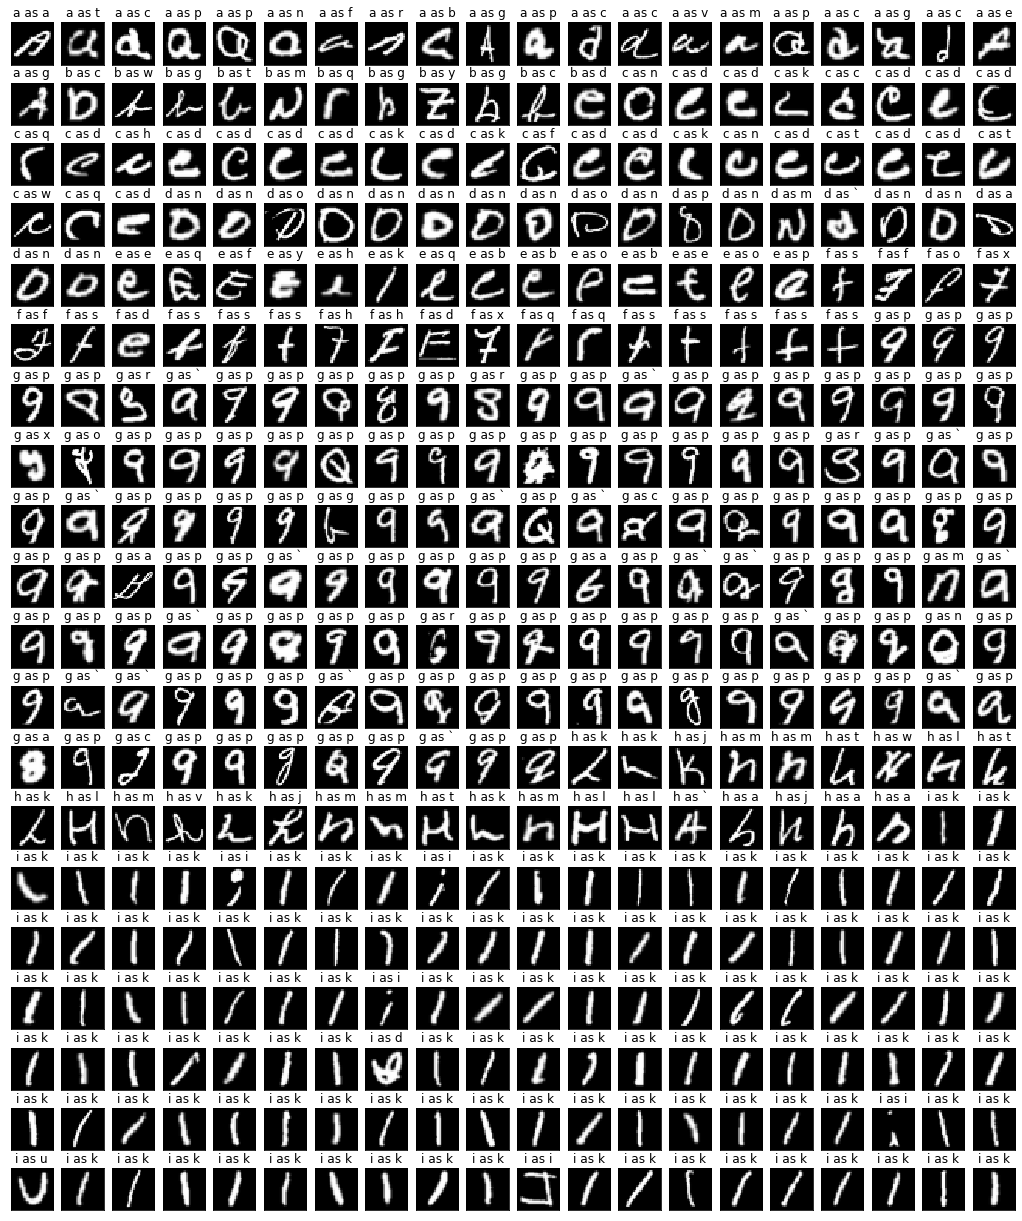

In [15]:
plt.figure(figsize=(18,22))
index = 0
for imageNumber in incorrects[0]:
    #print(imageNumber)
    plt.subplot(20,20,index+1)
    plt.imshow(X_test[imageNumber], cmap='gray')
    plt.title("{} as {}".format(chr(y_test[imageNumber]+96), chr(resultingClasses[imageNumber]+96)))
    plt.xticks([])
    plt.yticks([])
    index = index + 1
    if index >= 400:
        break